## The GIBBON (General-purpose Information-Based Bayesian OptimisatioN) acquisition function

A particularly intuitive and empirically effective class of acquisition functions has arisen based on information theory. Information-theoretic Bayesian Optimisation (BO) seeks to reduce uncertainty in the location of high-performing areas of the search space, as measured in terms of differential entropy. BoTorch already supports information-theoretic BO through an implementation of the Max-value Entropy Search (MES) acquisition function [1] (see the [Max-Value Entropy tutorial](/docs/tutorials/max_value_entropy) for details), which makes evaluations that reduce uncertainty in the maximum value attained by the objective function. However, in order to support batch and multi-fidelity BO, our implementation of MES employs numerical integrations and fantasy observations  (i. e., we generate one point each time and when we try to generate the 𝑖-th point of a batch, we condition the models on the 𝑖−1 points generated prior to this). Unfortunately,  Each of these calculations can can add significantly to the computational overhead incurred by BO.

In this notebook, we provide an information-theoretic acquisition function for tasks where objective function query costs are not large enough to overshadow significant optimisation overheads known as General-purpose Information-Based Bayesian OptimisatioN (GIBBON) [2]. In this tutorial, we present a very high-level overview of GIBBON and demonstrate its use within BoTorch.

### Calculating GIBBON

Following a principled information-theoretic construction, the GIBBON acquisition function measures the utility of evaluating a candidate batch of $B$ points $\{\textbf{x}\}_{i=1}^B$ as
$$
\begin{align}
    \alpha_{\text{GIBBON}}(\{\textbf{x}\}_{i=1}^B)
    &= \frac{1}{2}\log |C| + \sum_{i=1}^B  \hat{\alpha}_{\text{MES}}(\textbf{x}_i)
\end{align}
$$
where $|C|$ is the determinant of the $B\times B$ correlation matrix between the batch elements and $\hat{\alpha}_{\text{MES}}$ is an analytical approximation of the standard (non-batch) MES acquisition function. The GIBBON acquisition function forms a lower bound on the exact (but intractable) batch MES function and is consequently referred to as the `qLowerBoundMaxValueEntropy` in BoTorch. Crucially, GIBBON can be computed in closed-form and so incurs substantially lower overheads than batch MES via fantasies.

### Interpretating GIBBON
Note that the above decomposition of GIBBON has two terms and each has a helpful intuitive justification. In particular, the first term encourages diversity within the batch (achieving high values for points with low predictive correlation), whereas the second term ensures that evaluations are targeted in areas of the search space that provide large amounts of information about the maximum value attained by the objective function.


<br>
__References__


[1] [Wang, Z., Jegelka, S., _Max-value Entropy Search for Efficient Bayesian Optimization._ arXiv:1703.01968v3, 2018](https://arxiv.org/abs/1703.01968)

[2] [Moss, M., et al., _GIBBON: General-purpose Information-Based Bayesian Optimisation._  arXiv:2102.03324, 2020](https://arxiv.org/abs/2102.03324)


In [1]:
# Install dependencies if we are running in colab
import sys
if 'google.colab' in sys.modules:
    %pip install botorch

In [2]:
import os

SMOKE_TEST = os.environ.get("SMOKE_TEST")

### 1. Setting up a toy model
We will fit a standard SingleTaskGP model on noisy observations of the synthetic 2D SixHumpCamel function.

In [3]:
import math
import torch

from botorch.test_functions import SixHumpCamel
from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.utils.transforms import standardize, normalize
from gpytorch.mlls import ExactMarginalLogLikelihood

torch.manual_seed(123456)

bounds = torch.tensor(SixHumpCamel._bounds).T
bounds_norm = torch.tensor([[0.0, 0.0], [1.0, 1.0]])
train_X = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(5, 2)
train_Y = SixHumpCamel(negate=True)(train_X).unsqueeze(-1)

train_X = normalize(train_X, bounds=bounds)
train_Y = standardize(train_Y + 0.05 * torch.randn_like(train_Y))

model = SingleTaskGP(train_X, train_Y)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll, max_attempts=10);


[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.

[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


/var/folders/qq/w_95_j090j74hmlhqzqsgvyh0000gn/T/ipykernel_10939/2243645220.py:20: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(train_X, train_Y)


### 2. Defining the GIBBON acquisition function

GIBBON is implemented in BoTorch as `qLowerBoundMaxValueEntropy` and supports pending points through its `X_pending` argument. Required arguments for the constructor are `model` and `candidate_set` (the discretized candidate points in the design space that will be used to draw max value samples). There are also other optional parameters, such as number of max value samples. Just like in our implementation of MES, two different sampling algorithms are supported for the max value samples: discretized Thompson sampling and Gumbel sampling (the default choice). 
   

In [4]:
from botorch.acquisition.max_value_entropy_search import qLowerBoundMaxValueEntropy

candidate_set_size = 1000 if not SMOKE_TEST else 5
candidate_set = torch.rand(
    candidate_set_size, bounds_norm.size(1), device=bounds.device, dtype=bounds.dtype
)
qGIBBON = qLowerBoundMaxValueEntropy(model, candidate_set)

### 3. Optimizing the GIBBON acquisition function to get the next candidate points

In order to obtain the next candidate point(s) to query, we need to optimize the acquisition function over the design space. For $q=1$ case, we can simply call the `optimize_acqf` function in the library. For $q>1$,  we greedily build batches using sequential optimization. 


In [5]:
from botorch.optim import optimize_acqf

NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4

# for q = 1
candidates, acq_value = optimize_acqf(
    acq_function=qGIBBON,
    bounds=bounds,
    q=1,
    num_restarts=NUM_RESTARTS,
    raw_samples=RAW_SAMPLES,
)
candidates, acq_value

(tensor([[1.0589, 0.4887]]), tensor(0.0074))

In [6]:
from botorch.optim import optimize_acqf

# for q = 2, sequential optimsiation
candidates, acq_value = optimize_acqf(
    acq_function=qGIBBON,
    bounds=bounds,
    q=2,
    num_restarts=NUM_RESTARTS,
    raw_samples=RAW_SAMPLES,
    sequential=True,
)
candidates, acq_value

(tensor([[1.0589, 0.4887],
         [0.0494, 0.7331]]),
 tensor([0.0074, 0.0073]))

### 4. Comparing GIBBON with other acquisition functions

We now perform an illustrative comparison between GIBBON and the other low-cost acquisition functions implemented in BoTorch. We plot points chosen by each of the acquisition functions, each acquisition function's surface.


#### Sequential BO (q=1)

Firstly, we investigate GIBBON in the purely sequential case, comparing agaisnt MES, Expected Improvement (EI) and Probability of Improvement (PI). We see that GIBBON provides a very high-quality approximation of MES, choosing essentially the same location.


/Users/saitcakmak/botorch/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/opt/anaconda3/envs/botorch/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Text(-0.1, 0.5, 'x_2')

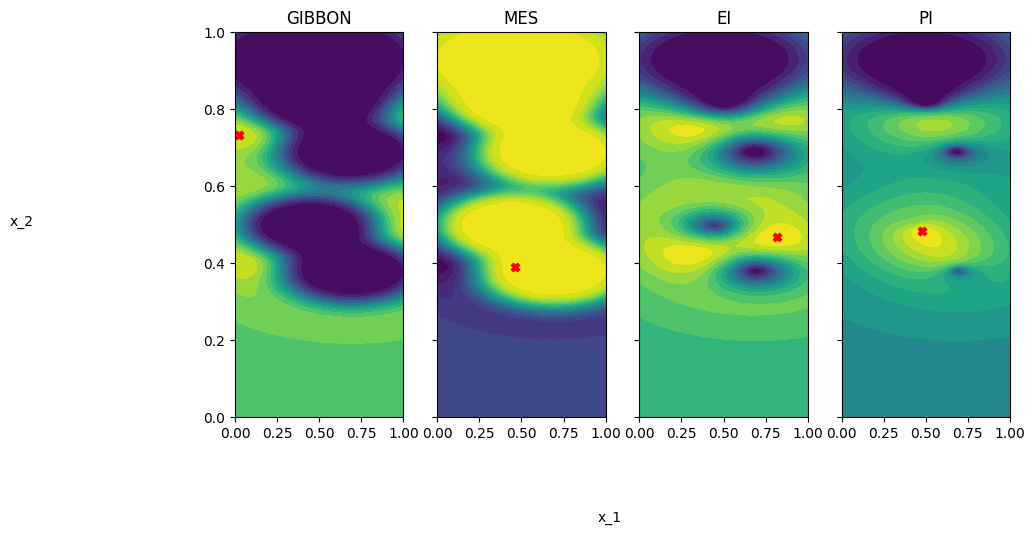

In [7]:
from botorch.acquisition import (
    ExpectedImprovement,
    ProbabilityOfImprovement,
    qMaxValueEntropy,
)
import matplotlib.pyplot as plt

%matplotlib inline

# prep different acqusition functions
acqs = {}
candidate_set = torch.rand(
    10000, bounds.size(1), device=bounds.device, dtype=bounds.dtype
)
acqs["GIBBON"] = qLowerBoundMaxValueEntropy(model, candidate_set)
acqs["MES"] = qMaxValueEntropy(model, candidate_set)
acqs["EI"] = ExpectedImprovement(model, best_f=train_Y.max())
acqs["PI"] = ProbabilityOfImprovement(model, best_f=train_Y.max())

# prep grid to evaluate acq functions
n = 100 if not SMOKE_TEST else 2
xv, yv = torch.meshgrid([torch.linspace(0, 1, n), torch.linspace(0, 1, n)])
test_x = torch.stack([xv.reshape(n * n, 1), yv.reshape(n * n, 1)], -1)

# eval and maximise acq functions
evals = {}
candidates = {}
for acq in acqs.keys():
    evals[acq] = acqs[acq](test_x).detach().reshape(n, n)
    candidates[acq], _ = optimize_acqf(
        acq_function=acqs[acq], bounds=bounds_norm, q=1, num_restarts=5, raw_samples=100
    )

# plot acqusition function values and chosen points
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    nrows=1, ncols=4, sharex=True, sharey=True, figsize=(10, 5)
)
ax1.contourf(xv.numpy(), yv.numpy(), evals["GIBBON"].numpy(), levels=20)
ax1.scatter(candidates["GIBBON"][:, 0], candidates["GIBBON"][:, 1], marker="X", c="r")
ax1.set_title("GIBBON")
ax2.contourf(xv.numpy(), yv.numpy(), evals["MES"].numpy(), levels=20)
ax2.scatter(candidates["MES"][:, 0], candidates["MES"][:, 1], marker="X", c="r")
ax2.set_title("MES")
ax3.contourf(xv.numpy(), yv.numpy(), evals["EI"].numpy(), levels=20)
ax3.scatter(candidates["EI"][:, 0], candidates["EI"][:, 1], marker="X", c="r")
ax3.set_title("EI")
ax4.contourf(xv.numpy(), yv.numpy(), evals["PI"].numpy(), levels=20)
ax4.scatter(candidates["PI"][:, 0], candidates["PI"][:, 1], marker="X", c="r")
ax4.set_title("PI")
fig.text(0.5, -0.1, "x_1", ha="center")
fig.text(-0.1, 0.5, "x_2", va="center")

#### Batch BO (q=3)

For the batch BO case, GIBBON selects similar points to MES but with an order-of-magnitude lower computational overhead, i.e perfoming information-theoretic BO at the cost of much simpler acqusition functions like EI and PI. We stress that this gap in computational overhead between GIBBON and MES grows substantially as the optimisation progresses (see [2]).

/Users/saitcakmak/botorch/botorch/acquisition/monte_carlo.py:502: NumericsWarning: qNoisyExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qNoisyExpectedImprovement 	 --> 	 qLogNoisyExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


/Users/saitcakmak/botorch/botorch/optim/optimize.py:309: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .')]
Trying again with a new set of initial conditions.
  candidate, acq_value = _optimize_acqf_batch(new_inputs)


Text(0.5, 0, 'Acquisition Function')

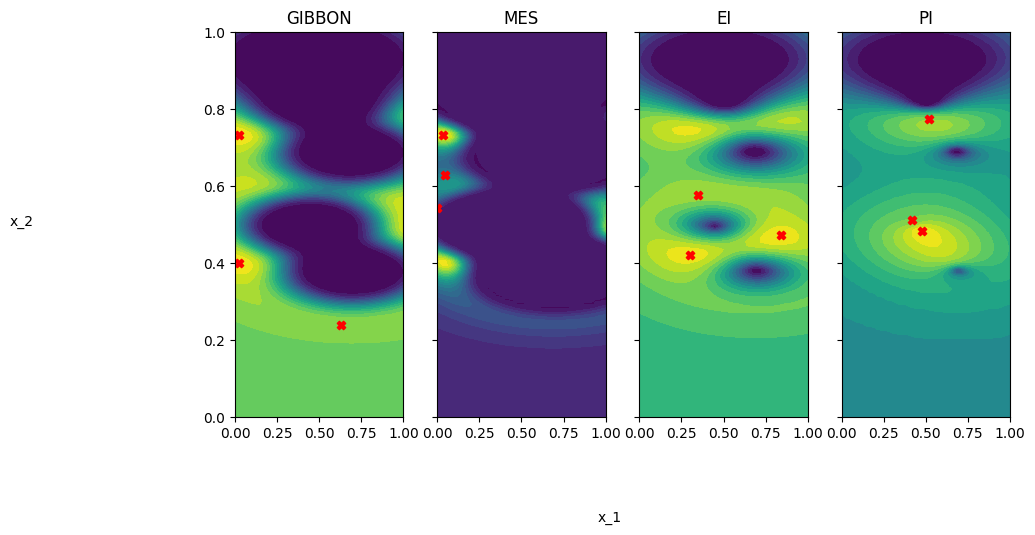

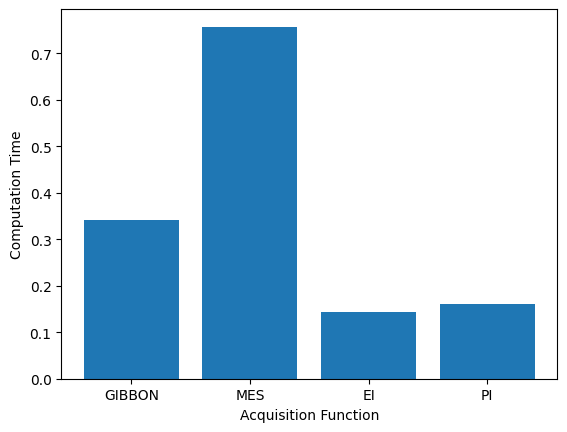

In [8]:
from botorch.acquisition import qNoisyExpectedImprovement, qProbabilityOfImprovement
from time import time

# prep different acqusition functions
acqs = {}
candidate_set = torch.rand(
    10000, bounds.size(1), device=bounds.device, dtype=bounds.dtype
)
acqs["GIBBON"] = qLowerBoundMaxValueEntropy(model, candidate_set)
acqs["MES"] = qMaxValueEntropy(model, candidate_set)
acqs["EI"] = qNoisyExpectedImprovement(model, train_X)
acqs["PI"] = qProbabilityOfImprovement(model, best_f=train_Y.max())

# prep grid to evaluate acq functions
n = 100 if not SMOKE_TEST else 2
xv, yv = torch.meshgrid([torch.linspace(0, 1, n), torch.linspace(0, 1, n)])
test_x = torch.stack([xv.reshape(n * n, 1), yv.reshape(n * n, 1)], -1)

# eval and maximise acq functions
evals = {}
candidates = {}
times = {}
for acq in acqs.keys():
    evals[acq] = acqs[acq](test_x).detach().reshape(n, n)
    t_0 = time()
    candidates[acq], _ = optimize_acqf(
        acq_function=acqs[acq],
        bounds=bounds_norm,
        q=3,
        num_restarts=5,
        raw_samples=100,
        sequential=True,
    )
    times[acq] = time() - t_0

# plot acqusition function values and chosen points
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    nrows=1, ncols=4, sharex=True, sharey=True, figsize=(10, 5)
)
ax1.contourf(xv.numpy(), yv.numpy(), evals["GIBBON"].numpy(), levels=20)
ax1.scatter(candidates["GIBBON"][:, 0], candidates["GIBBON"][:, 1], marker="X", c="r")
ax1.set_title("GIBBON")
ax2.contourf(xv.numpy(), yv.numpy(), evals["MES"].numpy(), levels=20)
ax2.scatter(candidates["MES"][:, 0], candidates["MES"][:, 1], marker="X", c="r")
ax2.set_title("MES")
ax3.contourf(xv.numpy(), yv.numpy(), evals["EI"].numpy(), levels=20)
ax3.scatter(candidates["EI"][:, 0], candidates["EI"][:, 1], marker="X", c="r")
ax3.set_title("EI")
ax4.contourf(xv.numpy(), yv.numpy(), evals["PI"].numpy(), levels=20)
ax4.scatter(candidates["PI"][:, 0], candidates["PI"][:, 1], marker="X", c="r")
ax4.set_title("PI")
fig.text(0.5, -0.1, "x_1", ha="center")
fig.text(-0.1, 0.5, "x_2", va="center")

# plot computational overheads
plt.figure()
heights = [times[acq] for acq in acqs.keys()]
plt.bar(acqs.keys(), heights)
plt.ylabel("Computation Time")
plt.xlabel("Acquisition Function")